<a href="https://colab.research.google.com/github/LaTsa99/DeepMinds/blob/master/DeepMinds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing necessary modules for data preprocessing**

In [1]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

**Downloading the zip file containing our training data**

In [2]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1UM65-NZoXAr3lydSkmX2OmHm63-PfepX -O /tmp/girls.zip

Downloading...
From: https://drive.google.com/uc?id=1UM65-NZoXAr3lydSkmX2OmHm63-PfepX
To: /tmp/girls.zip
126MB [00:01, 69.3MB/s]


**Unzipping the zip file containing the training data**

In [3]:
local_zip = '/tmp/girls.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

**Creating path strings to easily import the train data**

In [4]:
base_dir = os.path.join('/tmp', 'girls')

train_dir = os.path.join(base_dir, 'train')
train_bikini_dir = os.path.join(train_dir, 'bikini')
train_long_dir = os.path.join(train_dir, 'long')

valid_dir = os.path.join(base_dir, 'valid')
valid_bikini_dir = os.path.join(valid_dir, 'bikini')
valid_long_dir = os.path.join(valid_dir, 'long')

test_dir = os.path.join(base_dir, 'test')
test_bikini_dir = os.path.join(test_dir, 'bikini')
test_long_dir = os.path.join(test_dir, 'long')

**Querrying the filenames into variables**

In [5]:
bikini_train_fnames = os.listdir(train_bikini_dir)
bikini_valid_fnames = os.listdir(valid_bikini_dir)
bikini_test_fnames = os.listdir(test_bikini_dir)

long_train_fnames = os.listdir(train_long_dir)
long_valid_fnames = os.listdir(valid_long_dir)
long_test_fnames = os.listdir(test_long_dir)

**Setting the input image dimensions**

In [6]:
img_height = 299
img_width = 299

**Generating our data and making data generators**

In [30]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=10, zoom_range=0.2, horizontal_flip=True, rotation_range=20)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=20, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(img_height, img_width), batch_size=20, class_mode='binary')
test_generator  = test_datagen.flow_from_directory(test_dir, target_size=(img_height, img_width), batch_size=20, class_mode='binary', shuffle=False)

Found 1572 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 266 images belonging to 2 classes.


Importing necessary keras modules

In [8]:
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

Downloading pretrained model

In [9]:
base_model = InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


Creating the model

In [10]:
x = base_model.output                 # pretrained model
x = GlobalMaxPooling2D()(x)           # maxpooling layer to reduce size
x = Dropout(0.25)(x)                  # dropout
x = Dense(1024, activation='relu')(x) # fully connected layer
x = Dropout(0.1)(x)                   # dropout

predictions = Dense(1, activation='sigmoid')(x)             # output layer with 1 output true/false
model = Model(inputs=base_model.input, outputs=predictions) # create model

In [11]:
for layer in base_model.layers: # freezing the base model layers
  layer.trainable = False

model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy') # compiling model with optimizer adam

Callbacks

In [12]:
early_stopping = EarlyStopping(patience=10, verbose=1, min_delta=0.001)               # Early stopping to stop overfitting
checkpointer = ModelCheckpoint(filepath='model.hdf5', save_best_only=True, verbose=1) # Checkpointer to save the best model

Train the model

In [13]:
# Fitting the model with the generators for 5 epochs with the callback defined before
# train + validation datagenerator size ~ steps_per_epochs * validation_steps
model.fit(train_generator, steps_per_epoch=79, validation_data=valid_generator, validation_steps=26, epochs=100, callbacks=[early_stopping, checkpointer])

Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 1.7878 - accuracy: 0.8753
Epoch 00001: val_loss improved from inf to 0.12385, saving model to model.hdf5
79/79 [==============================] - 47s 599ms/step - loss: 1.7878 - accuracy: 0.8753 - val_loss: 0.1239 - val_accuracy: 0.9577
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.9701
Epoch 00002: val_loss improved from 0.12385 to 0.11409, saving model to model.hdf5
79/79 [==============================] - 46s 577ms/step - loss: 0.1037 - accuracy: 0.9701 - val_loss: 0.1141 - val_accuracy: 0.9596
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9688
Epoch 00003: val_loss did not improve from 0.11409
79/79 [==============================] - 45s 566ms/step - loss: 0.0840 - accuracy: 0.9688 - val_loss: 0.1560 - val_accuracy: 0.9500
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9726
Epoch 00004

Unfreezing the top of the pretrained model and fine tuning

In [14]:
for layer in model.layers[:172]:  # freezing the lower layers
  layer.trainable = False
for layer in model.layers[172:]:  # and unfreezing the upper layers
  layer.trainable = True

model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy') # compile again
# fitting with the same parameters
model.fit(train_generator, steps_per_epoch=79, validation_data=valid_generator, validation_steps=26, epochs=100, callbacks=[early_stopping, checkpointer])

Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9517
Epoch 00001: val_loss did not improve from 0.08272
79/79 [==============================] - 45s 573ms/step - loss: 0.1728 - accuracy: 0.9517 - val_loss: 8.8523 - val_accuracy: 0.7962
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9631
Epoch 00002: val_loss did not improve from 0.08272
79/79 [==============================] - 44s 560ms/step - loss: 0.1107 - accuracy: 0.9631 - val_loss: 80.1781 - val_accuracy: 0.5577
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9784
Epoch 00003: val_loss did not improve from 0.08272
79/79 [==============================] - 44s 556ms/step - loss: 0.0796 - accuracy: 0.9784 - val_loss: 57.8715 - val_accuracy: 0.7538
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9784
Epoch 00004: val_loss did not improve from 0.08272
79/79 [===========

Calculate test error and accuracy

In [33]:
from keras.models import load_model

model = load_model('model.hdf5')                                  # load the saved model
test_err = model.evaluate(test_generator)                         # evaluate test measurements
print('Test error:', test_err[0], 'Test accuracy:', test_err[1])  # print these


14/14 [==============================] - 3s 189ms/step - loss: 0.1116 - accuracy: 0.9549
Test error: 0.11156591773033142 Test accuracy: 0.9548872113227844


Confusion matrix

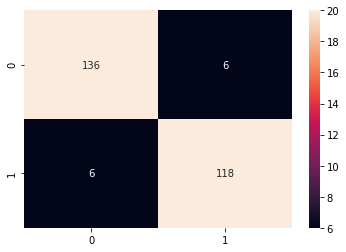

In [34]:
from tensorflow.math import confusion_matrix
import seaborn as sns

conf = confusion_matrix(test_generator.labels, np.round(model.predict(test_generator))) # Creating confusion matrix based on the test dataset
sns.heatmap(conf, annot=True, fmt='d', vmax=20) # Plotting the confusion matrix

Predict function

In [35]:
from tensorflow.keras.preprocessing import image

def predicter(img_path):
  test0  = image.load_img(img_path, target_size=(img_height, img_width))  # load the image
  x = image.img_to_array(test0)                                           # covert to numpy array
  x = x/255                                                               # rescale image
  x = np.expand_dims(x, axis=0)                                           # dimension expansion
  pred = model.predict(x)                                                 # and predict the image
  if pred > 0.5:                                                          # evaluate the prediction
    print('Appropriate')
  else:
    print('Inapporipriate')

Testing some inputs

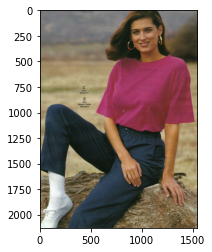

Appropriate


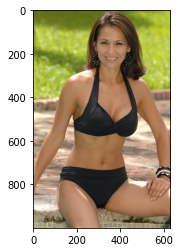

Inapporipriate


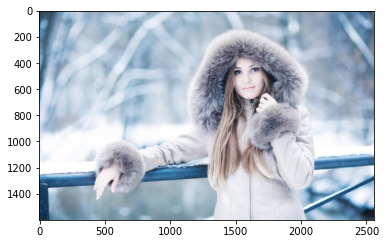

Appropriate


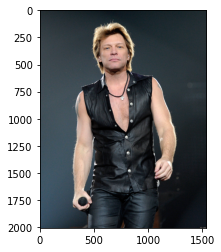

Appropriate


In [39]:
import matplotlib.pyplot as plt

for i in range(4):
  path = f"test{i}.jpg"
  image_file = image.load_img(path) # loading test image
  plt.imshow(image_file)            # plotting image
  plt.show()
  predicter(path)                   # predicting for image

Garbage collector

In [ ]:
import gc
gc.collect()

246